In [1]:
!pip install catboost
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from catboost import CatBoostRanker, Pool
from copy import deepcopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.7 MB/s eta 0:00:00


In [184]:
train_df = pd.read_csv('/content/train_df.csv')
test_df = pd.read_csv('/content/test_df.csv')

In [185]:
print(f'Количество объектов в трейне: {train_df.shape[0]},\nКоличество объектов в тесте: {test_df.shape[0]}')

Количество объектов в трейне: 15081,
Количество объектов в тесте: 1529


In [186]:
qs = np.unique(train_df['search_id'].values)

In [187]:
q_train, q_val = train_test_split(qs, test_size=0.2, random_state=13)

In [188]:
match_q_train, match_q_test = (train_df['search_id'].isin(q_train)), (train_df['search_id'].isin(q_val))
fin_X_train, fin_X_val = train_df[match_q_train], train_df[match_q_test]

In [189]:
q_train = fin_X_train['search_id'].values
y_train = fin_X_train['target'].values
x_train = fin_X_train.drop(columns=['search_id', 'target']).values

q_val = fin_X_val['search_id'].values
y_val = fin_X_val['target'].values
x_val = fin_X_val.drop(columns=['search_id', 'target']).values

q_test = test_df['search_id'].values
y_test = test_df['target'].values
x_test = test_df.drop(columns=['search_id', 'target']).values

In [190]:
def select_features(x_train, y_train, x_test):
    fs = SelectFromModel(RandomForestClassifier(n_estimators=100, max_features=17))
    fs.fit(x_train, y_train)
    X_train_fs = fs.transform(x_train)
    X_test_fs = fs.transform(x_test)
    return X_train_fs, X_test_fs, fs

x_train_select, x_test_select, fs = select_features(x_train, y_train, x_test)

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00190
Feature: 5, Score: 0.00485
Feature: 6, Score: 0.00215
Feature: 7, Score: 0.00198
Feature: 8, Score: 0.00319
Feature: 9, Score: 0.00304
Feature: 10, Score: 0.00091
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00190
Feature: 13, Score: 0.00430
Feature: 14, Score: 0.00178
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00521
Feature: 17, Score: 0.00665
Feature: 18, Score: 0.00110
Feature: 19, Score: 0.00253
Feature: 20, Score: 0.00401
Feature: 21, Score: 0.00963
Feature: 22, Score: 0.00285
Feature: 23, Score: 0.01286
Feature: 24, Score: 0.00975
Feature: 25, Score: 0.01039
Feature: 26, Score: 0.01291
Feature: 27, Score: 0.01844
Feature: 28, Score: 0.01183
Feature: 29, Score: 0.01435
Feature: 30, Score: 0.00876
Feature: 31, Score: 0.00254
Feature: 32, Score: 0.00316
Feature: 33, Score: 0.01275
Feature: 34, Score: 0.00857
Feature: 35, Score: 0.00496
Fe

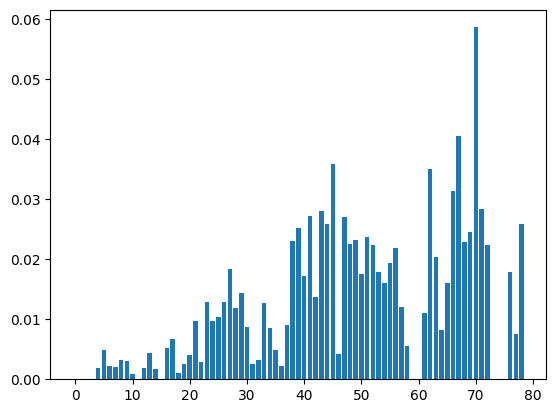

In [88]:
# попыталась посмотреть на важность признаков и отобрать наиболее значимые
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
feature_list = []
imp_list = []
imp = model.feature_importances_
for i, v in enumerate(imp):
    print('Feature: %0d, Score: %.5f' % (i, v))
    if v == 0.00000:
      feature_list.append(i)
    if v > 0.015:
      imp_list.append(i)
pyplot.bar([x for x in range(len(imp))], imp)
pyplot.show()

In [191]:
train_pool = Pool(data=x_train_select, label=y_train, group_id=q_train)
# val_pool = Pool(data=x_test_select, label=y_val, group_id=q_val)
test_pool = Pool(data=x_test_select, label=y_test, group_id=q_test)

In [192]:
default_parameters = {
    'iterations': 2000,
    'custom_metric': ['NDCG','AverageGain:top=10'],
    'verbose': False,
    'random_seed': 13}

In [193]:
def fit_model(loss_function, additional_params=None, train_pool=train_pool, test_pool=test_pool):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function

    if additional_params is not None:
        parameters.update(additional_params)

    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=True)

    return model

In [194]:
model = fit_model('YetiRank')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [197]:
model.load_model('/content/model_weights.cbm')

In [198]:
metric_val_test = model.score(x_test_select, y_test, group_id=q_test, top=len(y_test))
print(f"NDCG-test (CatBoostRanker): {metric_val_test}")

NDCG-test (CatBoostRanker): 0.9238199800776337


In [196]:
model.save_model('model_weights.cbm')

In [130]:
metric_val_test = model.score(x_test_select, y_test, group_id=q_test, top=len(y_test))
print(f"NDCG-test (CatBoostRanker): {metric_val_test}")

NDCG-test (CatBoostRanker): 0.927966837218043
